# **A. Import Libraries**

In [18]:
# Import Libraries
import os, shutil, random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf

# Import Module
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

---

# **B. Feature Engineering**

- Sumber Dataset : https://www.kaggle.com/datasets/680b9e2d7fc89cb1616f5c64d6a0af1b48e2aa3187559c38dda964bfb1c522be

In [19]:
# Split dataset train, test dan al 
# Path asal dataset
dataset_path = "Tire Textures"
output_path = r"Tire_Textures_Split"  # dataset hasil split

# Buat folder output (train, val, test)
for split in ["train", "val", "test"]:
    for label in os.listdir(dataset_path):
        os.makedirs(os.path.join(output_path, split, label), exist_ok=True)

# Split ratio
train_split = 0.5
val_split = 0.25
test_split = 0.25

# Loop tiap label
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if not os.path.isdir(label_path):
        continue
    
    images = os.listdir(label_path)
    random.shuffle(images)  # acak data
    
    n_total = len(images)
    n_train = int(train_split * n_total)
    n_val = int(val_split * n_total)
    
    # Bagi dataset
    train_files = images[:n_train]
    val_files = images[n_train:n_train+n_val]
    test_files = images[n_train+n_val:]
    
    # Copy file ke folder baru
    for f in train_files:
        shutil.copy(os.path.join(label_path, f), os.path.join(output_path, "train", label, f))
    for f in val_files:
        shutil.copy(os.path.join(label_path, f), os.path.join(output_path, "val", label, f))
    for f in test_files:
        shutil.copy(os.path.join(label_path, f), os.path.join(output_path, "test", label, f))

print("✅ Dataset berhasil dibagi ke dalam train, val, dan test set!")


✅ Dataset berhasil dibagi ke dalam train, val, dan test set!


In [20]:
# Define path
main_path = 'Tire_Textures_Split'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'val')

In [21]:
# Check how many data in `train_path` and `test_path`
def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')


Train Path
Total Data - cracked : 265
Total Data - normal : 245

Test Path
Total Data - cracked : 132
Total Data - normal : 122



---

## **B.1 - Preprocessing with Data Augmentation**

In [22]:
# Define hyperparameters
img_height= 220
img_width= 220
batch_size= 64

In [23]:
# Path dataset hasil split
base_path = "Tire_Textures_Split"
train_path = os.path.join(base_path, "train")
val_path   = os.path.join(base_path, "val")
test_path  = os.path.join(base_path, "test")

# Data augmentation untuk train
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Hanya normalisasi untuk val dan test
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Train generator
train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=2
)

# Val generator
val_set = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=2
)

# Test generator
test_set = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode="binary",
    batch_size=batch_size,
    shuffle=False
)


Found 510 images belonging to 2 classes.
Found 254 images belonging to 2 classes.
Found 257 images belonging to 2 classes.


In [24]:
# Show labels
train_set.class_indices

{'cracked': 0, 'normal': 1}

---

# **C. CNN Training**

## **C.1 - Model Definition**

In [25]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [26]:
# Create Sequential API model
model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,1)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(64, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(128, (3,3),activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(128, activation='relu'))
model_aug.add(Dense(2, activation='softmax'))

# Compile
model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_aug.summary()

c:\Users\Rivaldi Revin\miniconda3\envs\h8_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 218, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 107, 107, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,333,058 (39.42 MB)

 Trainable params: 10,333,058 (39.42 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Plot layers
tf.keras.utils.plot_model(model_aug, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


---

## **C.2 - Model Training**

In [28]:
# Train the model
history_aug = model_aug.fit(train_set, epochs=50, validation_data=val_set, batch_size=batch_size)

c:\Users\Rivaldi Revin\miniconda3\envs\h8_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 8s/step - accuracy: 0.5612 - loss: 0.7195 - val_accuracy: 0.4803 - val_loss: 0.7060
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.4883 - loss: 0.6999 - val_accuracy: 0.5748 - val_loss: 0.6816
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.5672 - loss: 0.6826 - val_accuracy: 0.5551 - val_loss: 0.6671
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.6266 - loss: 0.6588 - val_accuracy: 0.6181 - val_loss: 0.6414
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.6065 - loss: 0.6416 - val_accuracy: 0.6024 - val_loss: 0.6801
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.6211 - loss: 0.6653 - val_accuracy: 0.5551 - val_loss: 0.6990
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.6044 - loss: 0.6360 - val_accuracy: 0.6339 - val_loss: 0.6340
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.6715 - loss: 0.6051 - val_accuracy: 0.6378 - val_loss: 0.6270
Epoch 9/

---

## **C.3 - Model Evaluation**

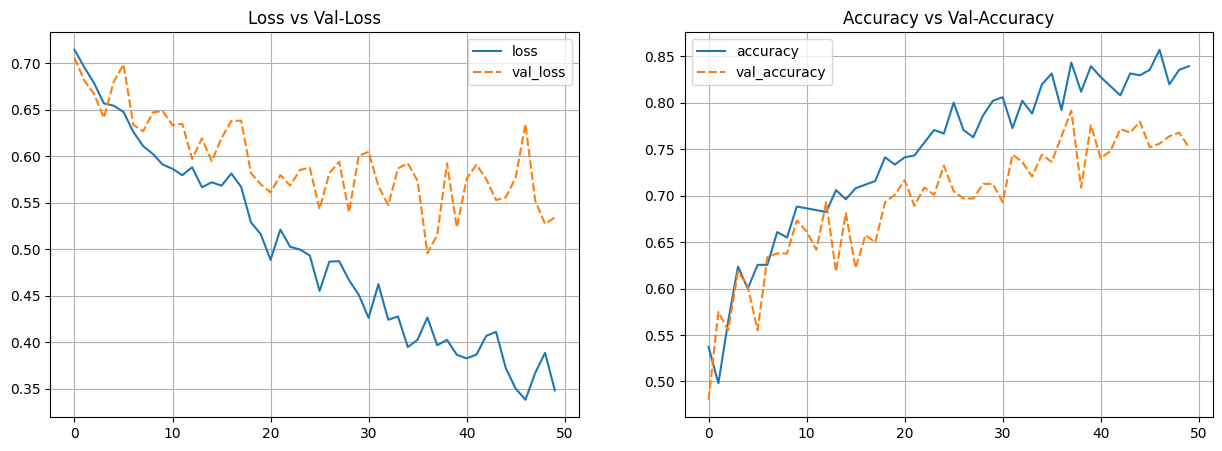

In [29]:
# Plot training results
history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

c:\Users\Rivaldi Revin\miniconda3\envs\h8_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


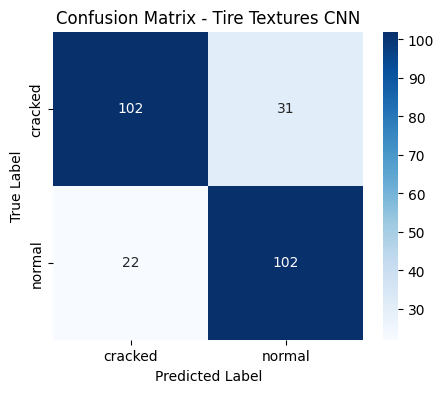

Classification Report:

              precision    recall  f1-score   support

     cracked       0.82      0.77      0.79       133
      normal       0.77      0.82      0.79       124

    accuracy                           0.79       257
   macro avg       0.79      0.79      0.79       257
weighted avg       0.80      0.79      0.79       257



In [30]:
# Prediksi probabilitas
y_pred_prob_aug = model_aug.predict(test_set)

# Karena binary classification, kita cek dulu bentuk output
if y_pred_prob_aug.shape[1] == 1:
    # Kalau output 1 neuron sigmoid → threshold 0.5
    y_pred_class_aug = (y_pred_prob_aug > 0.9).astype("int32").ravel()
else:
    # Kalau output softmax → ambil argmax
    y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

# True labels dari test set
y_true = test_set.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_class_aug)
labels = list(train_set.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Tire Textures CNN")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_class_aug, target_names=labels))


---

## **C.4 - Model Saving**

In [31]:
# Model summary
model_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 218, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 107, 107, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,999,176 (118.25 MB)

 Trainable params: 10,333,058 (39.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,666,118 (78.83 MB)

In [32]:
# Freeze model
model_aug.trainable = False
model_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 218, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 107, 107, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,999,176 (118.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,333,058 (39.42 MB)

 Optimizer params: 20,666,118 (78.83 MB)

In [33]:
# Save CNN model
model_aug.save('model_aug_ver6.keras', include_optimizer=True)